# Shrinkage Methods

In this review session, we are going to practice using the different shrinkage methods we learned in class. We are going to use LASSO, Ridge, and PCA to look at the dataset from [Angrist and Krueger (1991)](https://www.jstor.org/stable/2937954) that includes information on wage, education, and other demographic variables for men born between 1920 and 1929. 

## Setting Up

Before we start, let's load the libraries we are going to use

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

We will then load the dataset. This dataset contains information on weekly wages, education, quarter and year of birth for men born 1920-29 in 1970. The raw dataset can be found [here](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991).

In [2]:
df = pd.read_stata('../data/QOB7080_clean.dta')
df.columns

Index(['AGE', 'AGEQ', 'v3', 'EDUC', 'ENOCENT', 'ESOCENT', 'v7', 'LWKLYWGE',
       'MARRIED', 'MIDATL', 'MT', 'NEWENG', 'v14', 'v15', 'CENSUS', 'v17',
       'QOB', 'RACE', 'SMSA', 'SOATL', 'v22', 'v23', 'WNOCENT', 'WSOCENT',
       'v26', 'YOB', 'COHORT', 'AGEQSQ', 'YR20', 'YR21', 'YR22', 'YR23',
       'YR24', 'YR25', 'YR26', 'YR27', 'YR28', 'YR29', 'QTR1', 'QTR2', 'QTR3',
       'QTR4', 'QTR120', 'QTR121', 'QTR122', 'QTR123', 'QTR124', 'QTR125',
       'QTR126', 'QTR127', 'QTR128', 'QTR129', 'QTR220', 'QTR221', 'QTR222',
       'QTR223', 'QTR224', 'QTR225', 'QTR226', 'QTR227', 'QTR228', 'QTR229',
       'QTR320', 'QTR321', 'QTR322', 'QTR323', 'QTR324', 'QTR325', 'QTR326',
       'QTR327', 'QTR328', 'QTR329', 'QTR420', 'QTR421', 'QTR422', 'QTR423',
       'QTR424', 'QTR425', 'QTR426', 'QTR427', 'QTR428', 'QTR429'],
      dtype='object')

We will filter out most columns, leaving the ones we are interested in using. 

In [3]:
YOB = ['YR2' + str(i) for i in range(9)]
# Controlling for race, marital status, standrad metropolitan statistical areas, and regions of residence
controls = ['RACE', 'MARRIED', 'SMSA',
            'NEWENG', 'MIDATL', 'ENOCENT',
            'WNOCENT', 'SOATL', 'ESOCENT',
            'WSOCENT', 'MT']
y = df['LWKLYWGE']
X = df[['EDUC', 'AGEQ', 'AGEQSQ'] + YOB + controls]

Now, we will split the data by tenfold cross-validation.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Ridge Regression

First, we will look at how to implement a ridge regression. The parameter of the ridge regression are computed with the following equation:

\begin{align}
    \hat{\beta}^{ridge} = \arg\min_\beta \left\{\sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\}.
\end{align}

In other words, ridge regression is penalizing the sum-of-squares of the parameters. 

With a given $\lambda$, we can run the ridge regression like this:

In [5]:
ridgeReg = Ridge(alpha=0.5, normalize=True)
ridgeReg.fit(X_train, y_train)
pd.DataFrame({'var':X.columns, 'val':ridgeReg.coef_})

,var,val
0,EDUC,4.843693e-02
1,AGEQ,1.014126e-04
2,AGEQSQ,3.860617e-07
3,YR20,-6.112852e-03
4,YR21,-6.901356e-04
5,YR22,-3.615012e-03
6,YR23,1.474713e-03
7,YR24,3.022267e-03
8,YR25,7.385316e-03
9,YR26,7.349343e-03


We can check what $\alpha$ value we should choose based on validation error. 

In [6]:
alphas = np.linspace(0.01, 5, num=51)
cv_errs = []
coefs = []
for alpha in alphas:
    ridgeReg = Ridge(alpha=alpha, normalize=True)
    ridgeReg.fit(X_train, y_train)
    y_pred = ridgeReg.predict(X_test)
    cv_errs.append(np.mean((y_pred - y_test)**2))
    coefs.append(ridgeReg.coef_)
coefs = pd.DataFrame(coefs, columns=X.columns)
coefs.set_index(alphas, inplace=True)

Text(0, 0.5, 'Mean Squared Error')

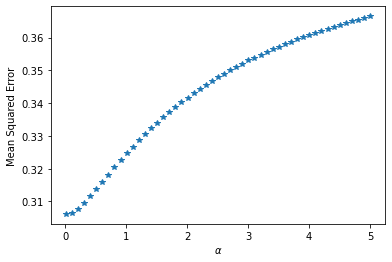

In [7]:
plt.plot(alphas, cv_errs, '*')
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')

<AxesSubplot:>

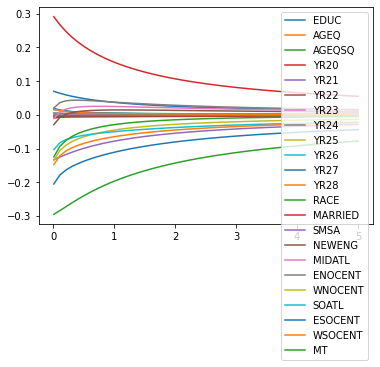

In [8]:
coefs.plot()

Alternatively, this can be done with the method `RidgeCV`

In [9]:
ridgeReg = RidgeCV(alphas=alphas, cv=10, normalize=True).fit(X, y)
ridgeReg.alpha_

0.01

## LASSO

We will now implement the LASSO regression. The parameter of the LASSO regression are computed with the following equation:

\begin{align}
    \hat{\beta}^{LASSO} = \arg\min_\beta \left\{\sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij}\beta_j)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\}.
\end{align}


In other words, LASSO regression is penalizing the sum of the absolute values of the parameters. 

With a given $\lambda$, we can run the LASSO regression like this:


In [10]:
lassoReg = LassoCV(alphas=[1e-6, 1e-4, 1e-2, 1], cv=10, normalize=True).fit(X, y)
lassoReg.alpha_

1e-06

In [11]:
lassoReg = Lasso(alpha=1e-6, normalize=True)
lassoReg.fit(X_train, y_train)
pd.DataFrame({'var':X.columns, 'val':lassoReg.coef_})

,var,val
0,EDUC,0.070325
1,AGEQ,0.001180
2,AGEQSQ,0.000000
3,YR20,-0.002734
4,YR21,0.000000
5,YR22,-0.000720
6,YR23,0.003271
7,YR24,0.004754
8,YR25,0.012964
9,YR26,0.012596


An important point to keep in mind is that, we need to be careful with making causal claims when we use shrinkage methods such as LASSO. LASSO is penalized to drop parameters that are correlated, which means it can drop the true regressor that is causing fluctuations of the dependent variable. Thus, LASSO's advantage is in prediction, but not in causality determination. 

## Principal Component Analysis

Now, I will give an example of principal component analysis. Before we run principal component analysis, we want to standardize the data, so variables are comparable with each other. If not, the PCA will select to project in the direction of the variable with the largest variance. 

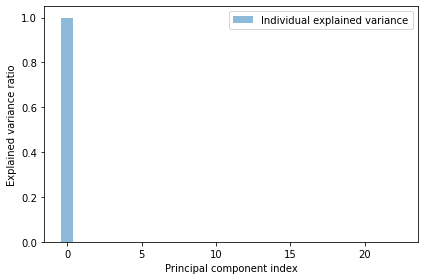

In [12]:
pca = PCA()
X_pca = pca.fit_transform(X)
exp_var_pca = pca.explained_variance_ratio_
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As we can see below, the high variance of **AGESQ** probably contributed to the high explained variance for the first principal component. 

In [13]:
X.var()

EDUC          11.294059
AGEQ           8.282322
AGEQSQ     67482.093750
YR20           0.086733
YR21           0.090624
YR22           0.088596
YR23           0.088819
YR24           0.092483
YR25           0.090200
YR26           0.089084
YR27           0.093225
YR28           0.089536
RACE           0.075333
MARRIED        0.095697
SMSA           0.210798
NEWENG         0.049979
MIDATL         0.158713
ENOCENT        0.169916
WNOCENT        0.065997
SOATL          0.127399
ESOCENT        0.053058
WSOCENT        0.079520
MT             0.036793
dtype: float64

We now standardize the dataframe, and run PCA again. 

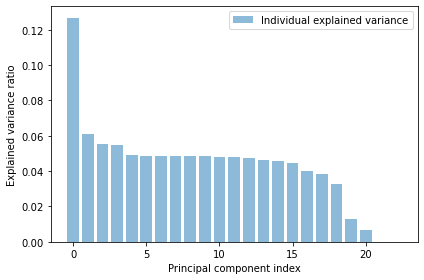

In [14]:
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)
X_sc_pca = pca.fit_transform(X_sc)
exp_var_sc_pca = pca.explained_variance_ratio_
plt.bar(range(0,len(exp_var_sc_pca)), exp_var_sc_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

To get a n-dimensional PCA-transformed matrix, we simply do: 

In [15]:
n = 2
pca_n = PCA(n_components=n)
pca_n.fit_transform(X_sc)

array([[-1.8866111 ,  1.6324784 ],
       [-1.6969872 ,  1.0002016 ],
       [-2.3974164 ,  1.0064664 ],
       ...,
       [ 0.9516566 ,  2.2698681 ],
       [ 0.7976789 ,  1.5285988 ],
       [ 0.04424192,  1.6283612 ]], dtype=float32)